# 1.0- Imports and Load Dataset

## 1.1- Imports

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import re 
import os 
import string 
import keras 
import nltk 
import random 
import plotly.express as px
import plotly.figure_factory as ff
import spacy 

from plotly import graph_objs as go
from PIL import Image
from wordcloud import WordCloud , STOPWORDS , ImageColorGenerator 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tqdm import tqdm 
from collections import Counter , defaultdict
from keras.preprocessing.text import Tokenizer 
from keras.utils import pad_sequences
from keras.callbacks import ModelCheckpoint  , ReduceLROnPlateau
from keras.optimizers import Adam
from keras.models import Sequential 
from keras.initializers import Constant 
from keras.layers import Dense , LSTM ,Embedding , BatchNormalization ,Dropout ,Bidirectional , Flatten ,GlobalMaxPool1D
from sklearn.metrics import confusion_matrix , classification_report , accuracy_score ,f1_score

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## 1.2- Load Data

In [2]:
data =  pd.read_csv('spam.csv' , encoding = 'latin')
data = data.drop(['Unnamed: 2' ,'Unnamed: 3' , 'Unnamed: 4'] , axis=1)
data.columns = ['Target', 'Message']
data.reset_index()
data.head()

,Target,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# 2.0- EDA

In [3]:
# let's get length of each message 

data['message_length'] = data['Message'].apply(lambda x: len(x.split(" ")))
data.head()

,Target,Message,message_length
0,ham,"Go until jurong point, crazy.. Available only ...",20
1,ham,Ok lar... Joking wif u oni...,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28
3,ham,U dun say so early hor... U c already then say...,11
4,ham,"Nah I don't think he goes to usf, he lives aro...",13


## 2.1- Visualizing Imbalanced Data

In [4]:
data['Target'].value_counts()

Target
ham     4825
spam     747
Name: count, dtype: int64

# 3.0- Preprocessing The Dataset

## 3.1- Do operations

3.3- Vectorization
3.4- Do TFIDF Method

In [6]:


stop_words = stopwords.words('english') + ['u', 'im', 'c'] 
stemmer = nltk.SnowballStemmer('english')



def clean_text(text):
    '''Do lowercase, remove text in square brackets,links, punctuation
    and words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text


def preprocessing(text):
    
    cleaned_text = clean_text(text) 
    # remove stopwords 
    cleaned_text  = ' '.join(word for word in cleaned_text.split(' ') if word not in stop_words)
    # do stem method 
    cleaned_text  = ' '.join(stemmer.stem(word) for word in cleaned_text.split(' '))
    return cleaned_text


In [7]:
data['Cleaned_Message'] = data['Message'].apply(preprocessing)
# let's show new length after process 

data['New_length'] = data['Cleaned_Message'].apply(lambda x: len(x.split(' ')))
data.head()

,Target,Message,message_length,Cleaned_Message,New_length
0,ham,"Go until jurong point, crazy.. Available only ...",20,go jurong point crazi avail bugi n great world...,16
1,ham,Ok lar... Joking wif u oni...,6,ok lar joke wif oni,5
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entri wkli comp win fa cup final tkts m...,23
3,ham,U dun say so early hor... U c already then say...,11,dun say earli hor alreadi say,6
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nah dont think goe usf live around though,8


## 3.2- Tokens Visualization

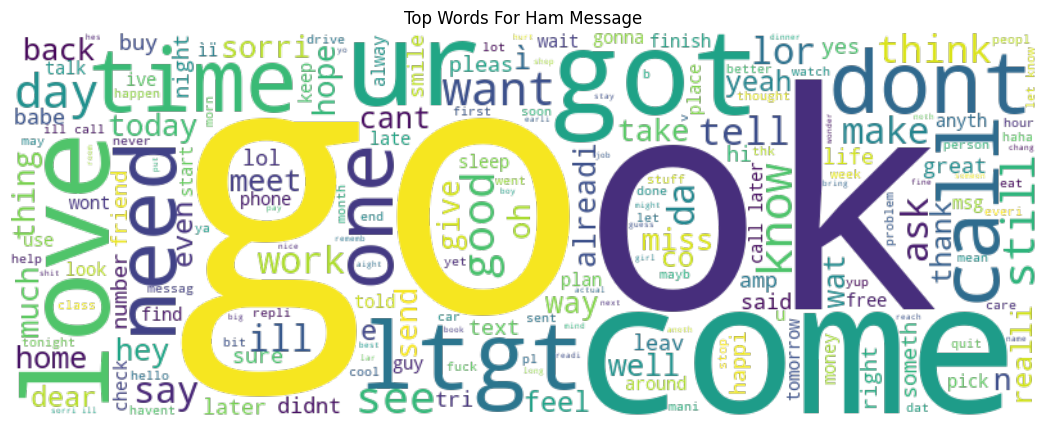

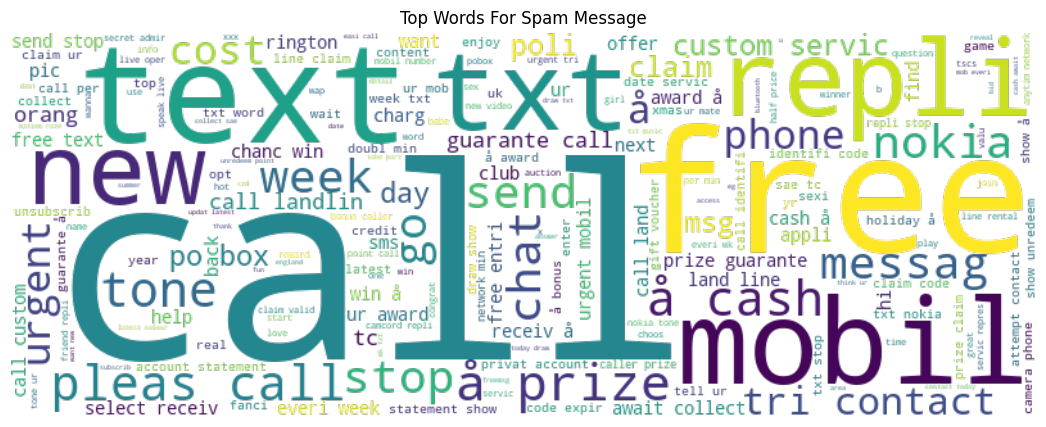

In [8]:
plt.figure(figsize = (16,5))
plt.title('Top Words For Ham Message')

Word_ham = WordCloud( 
    background_color=None, mode="RGBA" , 
    width=800, 
    height=300,
    )

Word_ham.generate(' '.join(text for text in  data.loc[ data['Target']=='ham' , 'Cleaned_Message']))
plt.imshow(Word_ham, interpolation='bilinear')
plt.axis('off')
plt.show()


plt.figure(figsize = (16,5))
plt.title('Top Words For Spam Message')

Word_spam = WordCloud( 
    background_color=None, mode="RGBA" , 
    width=800, 
    height=300,
    )

Word_spam.generate(' '.join(text for text in  data.loc[ data['Target']=='spam' , 'Cleaned_Message']))
plt.imshow(Word_spam, interpolation='bilinear')
plt.axis('off')
plt.show()

    

## 3.3- Do TFIDF Method

In [9]:
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split
Encoder = LabelEncoder()

y_label   = Encoder.fit_transform(data['Target'])
train_data= data['Cleaned_Message']

X_train ,X_test , y_train , y_test = train_test_split(train_data , y_label , test_size=0.2 , random_state=42)


In [10]:
from sklearn.feature_extraction.text import TfidfTransformer , CountVectorizer

TF_model = TfidfTransformer()
Vec_model= CountVectorizer()

Vec_model.fit(X_train)
X_train_vec = Vec_model.transform(X_train) 
X_test_vec  = Vec_model.transform(X_test)

TF_model.fit(X_train_vec)
X_train_tfidf = TF_model.transform(X_train_vec)
X_test_tfidf  = TF_model.transform(X_test_vec)

X_train_tfidf

<4457x5955 sparse matrix of type '<class 'numpy.float64'>'
	with 34735 stored elements in Compressed Sparse Row format>

# 4.0- Model and Make Prediction


# 4.1- Naive Bayes Model

In [11]:
from sklearn.naive_bayes import MultinomialNB

NB_model = MultinomialNB()

# train the model 
NB_model.fit(X_train_tfidf ,y_train)

MultinomialNB()

## evalute NB_model

In [12]:
NB_prediction = NB_model.predict(X_test_tfidf)

NB_confusion = confusion_matrix(NB_prediction , y_test) 
NB_report    = classification_report(NB_prediction , y_test)
NB_accuracy  = accuracy_score(NB_prediction , y_test)

dash_line    = ' '.join('-' for _ in range(100))

print(f'Naive Bayes Confusion Matrix :\n{NB_confusion}')
print(dash_line)
print(f'Naive Bayes Classification Report :\n{NB_report}')
print(dash_line)
print(f'Naive Bayes Accuracy :\n{NB_accuracy}')

Naive Bayes Confusion Matrix :
[[965  40]
 [  0 110]]
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Naive Bayes Classification Report :
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      1005
           1       0.73      1.00      0.85       110

    accuracy                           0.96      1115
   macro avg       0.87      0.98      0.91      1115
weighted avg       0.97      0.96      0.97      1115

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Naive Bayes Accuracy :
0.9641255605381166


## 4.3- BERT and Evaluate

In [13]:
import tensorflow as tf
from tensorflow import keras 
from keras.layers import Dense  , Input
from keras.optimizers import Adam 
from keras.models import Model
from keras.callbacks import ModelCheckpoint

import transformers
from transformers import BertTokenizer , TFBertModel

In [14]:
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')
bert_model= TFBertModel.from_pretrained('bert-large-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [15]:
# let's create a function to encode our input text to extract 'input_ids', and 'attention_maske'


def encode_(data , max_len):
    ids_list = []
    mask_list= []
    
    for text in data:
        text_encode = tokenizer.encode_plus(
        
            text ,
            max_length = max_len , 
            add_special_tokens=True ,
            truncation=True,
            padding='max_length' , 
            return_attention_mask=True
        )
        ids_list.append(text_encode['input_ids'])
        mask_list.append(text_encode['attention_mask'])
    return np.array(ids_list) , np.array(mask_list)
        


In [16]:
train_input_ids , train_attention_mask = encode_(train_data ,60)


### Create Bert Model

In [17]:
def create_bert_model(bert_model):
    input_ids     = Input(shape=(60,) , dtype='int32') 
    attention_mask= Input(shape=(60,) , dtype='int32')
    ### layers
    out = bert_model(input_ids ,attention_mask)[1]
    out = Dense(32 , activation='relu')(out)
    out = Dropout(0.2)(out)
    out = Dense(1 , activation ='sigmoid')(out)
    ### initiate the model
    model = Model(inputs = [input_ids , attention_mask] , outputs = out)
    
    model.compile(Adam(learning_rate=1e-5) , loss =  'binary_crossentropy' , metrics = ['accuracy'])
    
    return model


Bert_model = create_bert_model(bert_model)
Bert_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  335141888   ['input_1[0][0]',                
                                thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 60,                                            

### training the model

In [18]:
history = Bert_model.fit(
    [train_input_ids , train_attention_mask] ,
    y_label ,
    validation_split = 0.2,
    epochs = 5 , 
    batch_size=16

)


Epoch 1/5
279/279 [==============================] - 161s 468ms/step - loss: 0.1634 - accuracy: 0.9470 - val_loss: 0.0884 - val_accuracy: 0.9695
Epoch 2/5
279/279 [==============================] - 135s 485ms/step - loss: 0.0698 - accuracy: 0.9800 - val_loss: 0.0706 - val_accuracy: 0.9794
Epoch 3/5
279/279 [==============================] - 135s 485ms/step - loss: 0.0348 - accuracy: 0.9926 - val_loss: 0.0649 - val_accuracy: 0.9839
Epoch 4/5
279/279 [==============================] - 135s 485ms/step - loss: 0.0329 - accuracy: 0.9915 - val_loss: 0.0629 - val_accuracy: 0.9901
Epoch 5/5
279/279 [==============================] - 135s 485ms/step - loss: 0.0213 - accuracy: 0.9951 - val_loss: 0.0550 - val_accuracy: 0.9839


In [19]:
def plot_history(history, arr):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    for index in range(2):
        ax[index].plot(history.history[arr[index][0]])
        ax[index].plot(history.history[arr[index][1]])
        ax[index].legend([arr[index][0], arr[index][1]],fontsize=18)
        ax[index].set_xlabel('Value',fontsize=16)
        ax[index].set_ylabel('Percentage',fontsize=16)
        ax[index].set_title(arr[index][0] + ' X ' + arr[index][1],fontsize=16)

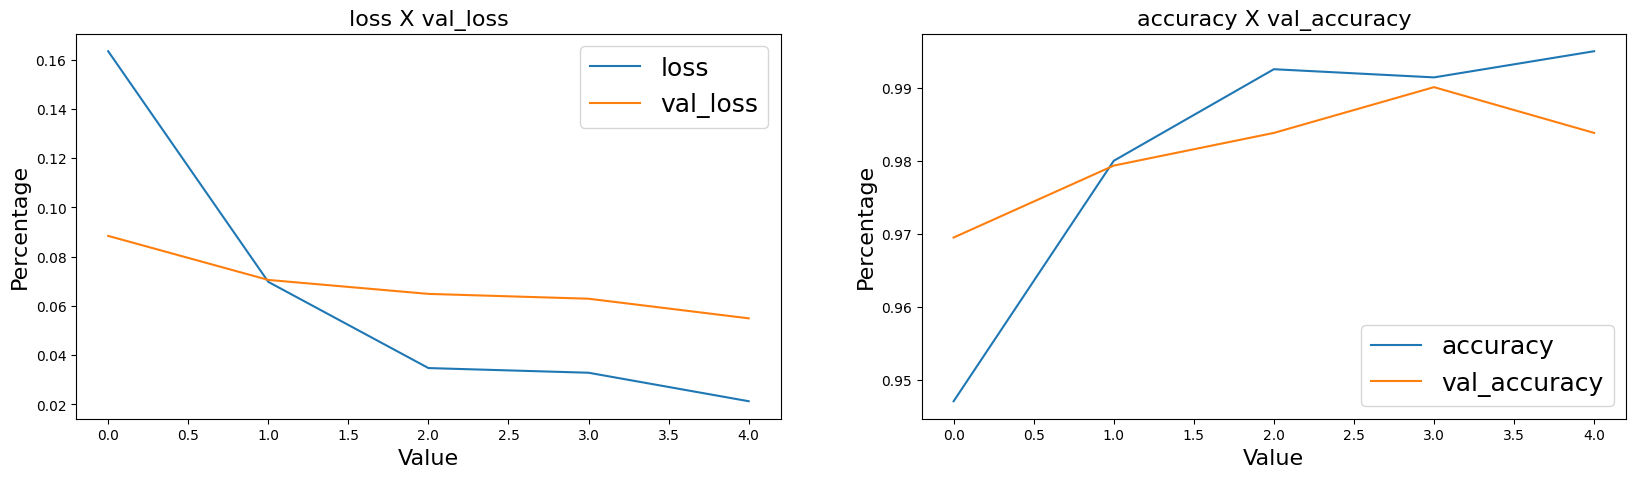

In [20]:
plot_history(history , [['loss', 'val_loss'],['accuracy', 'val_accuracy'] ])

``` The following section is optional. You can achieve remarkable accuracy by following the instructions provided above. In this particular section, we will load the FLAN-T5 model and apply a prompt engineering approach to assess the model's performance. While the success of this task is not contingent on it, our objective is to demonstrate the capabilities of a Large Language Model in handling diverse tasks. Let us proceed.```

## 4.4- FLAN-T5 and Evaluate

In [21]:
import numpy as np
import pandas as pd
import torch
import warnings
import time
# import evaluate

from pathlib import Path
from string import Template
from transformers import AutoModelForSeq2SeqLM , AutoTokenizer 
warnings.simplefilter('ignore')

In [22]:
model_name = 'google/flan-t5-base'

Flan_model = AutoModelForSeq2SeqLM.from_pretrained(model_name , torch_dtype = torch.bfloat16)
tokenizer      = AutoTokenizer.from_pretrained(model_name)

### Test the Model with Zero shot inference

In [23]:
preamble = "Classify the following SMS message as either 'ham' or 'spam':"
end_prompt   = 'Answer:\n'

template =  Template('$preamble\n\n$prompt\n\n$end_prompt')



def create_prompt(data , index):
    prompt = data.loc[index , 'Message']
    
    input_text = template.substitute(preamble=preamble , prompt = prompt ,end_prompt=end_prompt)
    return input_text 


In [24]:
print(create_prompt(data , 0))

Classify the following SMS message as either 'ham' or 'spam':

Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

Answer:



In [25]:
import random
index = random.randint(0,200)

zero_shot_message = create_prompt(data , index) 
zero_shot_class   = data.loc[index , 'Target']


inputs  = tokenizer(zero_shot_message , return_tensors='pt')
generate= Flan_model.generate(inputs['input_ids'] )[0]
model_answer = tokenizer.decode(generate , skip_special_tokens=True)


line_dash = '-'.join('' for _ in range(100))
print(line_dash)
print(line_dash)
print(f'Prompt:\n{zero_shot_message}')
print(line_dash)
print(f'Acual Answer:\n{zero_shot_class}')
print(line_dash)
print(f'Model Answer:\n{model_answer}')


---------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------
Prompt:
Classify the following SMS message as either 'ham' or 'spam':

FreeMsg Why haven't you replied to my text? I'm Randy, sexy, female and live local. Luv to hear from u. Netcollex Ltd 08700621170150p per msg reply Stop to end

Answer:

---------------------------------------------------------------------------------------------------
Acual Answer:
spam
---------------------------------------------------------------------------------------------------
Model Answer:
spam


```As can be seen, the model in the classification task is not optimized for this purpose, as it's not its primary focus. Therefore, it's advisable to use the BERT model for classification tasks in NLP.```